In [28]:
# Import Dependencies
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score 

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import matplotlib.pyplot as plt
from joblib import dump, load
# from pickle import dump
import sqlite3

In [29]:
# Call in the data
df = pd.read_csv('Resources/preprocessed.csv').drop(['Unnamed: 0'], axis=1)
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,_5,9.99,7.99,1,0,245
1,_1,_1,_6,9.99,7.99,1,1,453
2,_1,_1,_7,9.99,7.99,1,0,409
3,_1,_1,_8,9.99,7.99,1,0,191
4,_1,_1,_9,9.99,9.99,0,0,145


## Migrating Data From Pythonto SQL

In [30]:
# Set up connection
conn=sqlite3.connect('Resources/db.sqlite')

In [31]:
# Convert Pandas DataFrame to SQL Database
# df.to_sql('profitPredictor_db', conn, if_exists='replace', index=False)

In [32]:
#  Confirm data is in SQL database. 
pd.read_sql('select * from profitPredictor_db', conn)

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,_5,9.99,7.99,1,0,245
1,_1,_1,_6,9.99,7.99,1,1,453
2,_1,_1,_7,9.99,7.99,1,0,409
3,_1,_1,_8,9.99,7.99,1,0,191
4,_1,_1,_9,9.99,9.99,0,0,145
...,...,...,...,...,...,...,...,...
3856,_10,_3,_39,19.99,19.99,0,0,133
3857,_10,_3,_40,19.99,19.99,0,0,133
3858,_10,_3,_41,19.99,19.99,0,0,127
3859,_10,_3,_42,19.99,19.99,0,0,133


In [33]:
# Assign product variables
pro1=df[df['Product']=='_1']
pro2=df[df['Product']=='_2']
pro3=df[df['Product']=='_3']    

In [34]:
# Create features
X=df.drop(columns=['Weekly_Units_Sold'], axis = 1)

X=pd.get_dummies(X)

# Create target. 
y = df['Weekly_Units_Sold']

## Gradient Boosting Regression

In [35]:
model=GradientBoostingRegressor()
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculating Cross Validation Score across multiple testing sets
scores = cross_val_score(model, X_train_scaled, y_train, cv=20)
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


model.fit(X_train_scaled, y_train)
pred=model.predict(X_test_scaled)

# for classification we use accuracy and F1 score
print(model.score(X_train_scaled,y_train))
print(model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

0.88 accuracy with a standard deviation of 0.07
0.9036436493215062
0.8140023438237635
43.30690672930622
0.8140023438237635


## Feature Importance on the Model

Text(0, 0.5, 'Feature Importance Score')

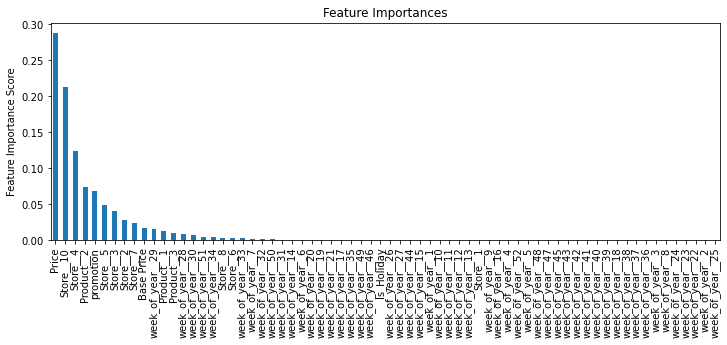

In [36]:
feat_imp = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [37]:
cross_val_score(model, X_train_scaled, y_train, cv=10)

array([0.89406359, 0.93226116, 0.89376213, 0.83312848, 0.88488664,
       0.90094371, 0.86786623, 0.76095428, 0.82520686, 0.91867527])

In [38]:
(scores.mean(), scores.std())

(0.8795070405591744, 0.06799575598016341)

In [39]:
print(dir(GradientBoostingRegressor))
GradientBoostingRegressor()

['_SUPPORTED_LOSS', '__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_check_initialized', '_check_n_features', '_check_params', '_clear_state', '_compute_partial_dependence_recursion', '_estimator_type', '_fit_stage', '_fit_stages', '_get_param_names', '_get_tags', '_init_state', '_is_initialized', '_make_estimator', '_more_tags', '_raw_predict', '_raw_predict_init', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_resize_state', '_staged_raw_predict', '_validate_data',

GradientBoostingRegressor()

## Hypertuning the Model

In [13]:
GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.045, 0.05, 0.055, 0.06, 0.065],
              'subsample'    : [0.09, 0.085, 0.08, 0.075, 0.07],
              'n_estimators' : [900, 950, 1000, 1050, 1100],
              'max_depth'    : [6, 7, 8, 9, 10]
             }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train_scaled, y_train)

# Generate predictions
y_pred = grid_GBR.predict(X_test_scaled)

# Generate r-squared
score = r2_score(y_test, y_pred)

print("Results from Grid Search")
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)
print("\n r-squared:\n",score)

KeyboardInterrupt: 

## Final Hypertuned Model 

In [40]:
X_train

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
3550,10.99,8.79,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3016,9.99,7.99,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1057,5.99,5.99,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2730,5.99,5.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2466,19.99,19.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,9.99,9.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1344,10.99,10.99,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
527,10.99,10.99,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3197,5.99,5.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
model=GradientBoostingRegressor(learning_rate=0.055, max_depth=10, n_estimators=1100, subsample=0.09)
# # Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

predicted_values=[]

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculating Cross Validation Score across multiple testing sets
scores = cross_val_score(model, X_train_scaled, y_train, cv=20)
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


model.fit(X_train_scaled, y_train)
pred=model.predict(X_test_scaled)

# pred.append(predicted_values)

# for classification we use accuracy and F1 score
print(model.score(X_train_scaled,y_train))
print(model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

0.93 accuracy with a standard deviation of 0.05
0.9873328803670055
0.9287777490027918
27.02087100548556
0.9287777490027918


In [42]:
X_test

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
2435,19.99,19.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2362,5.99,4.01,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
235,5.99,5.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2112,19.99,19.99,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1350,10.99,10.99,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,21.99,21.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2987,19.99,10.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3107,10.99,8.79,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
57,10.99,10.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# X_test_scaled['Weekly_Units_Sold']= pred

pred_units=pd.Series(pred)
pred_units.describe()

count     966.000000
mean      208.935916
std       231.450608
min       -78.952284
25%        68.470355
50%       126.212518
75%       259.598452
max      2059.283470
dtype: float64

## Feature Importance on the Hypertuned Model

Text(0, 0.5, 'Feature Importance Score')

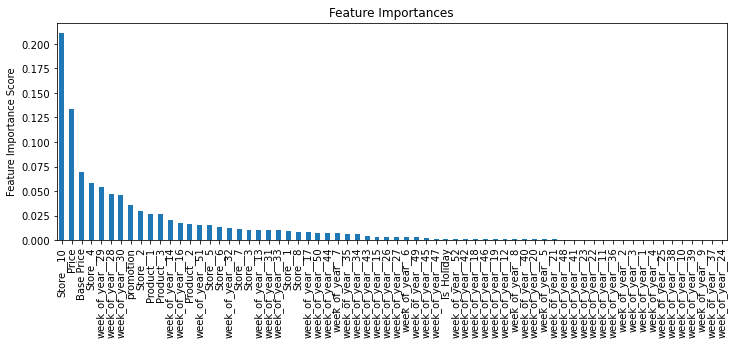

In [44]:
feat_imp = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Export Model

In [47]:
X_train

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
3550,10.99,8.79,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3016,9.99,7.99,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1057,5.99,5.99,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2730,5.99,5.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2466,19.99,19.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,9.99,9.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1344,10.99,10.99,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
527,10.99,10.99,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3197,5.99,5.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# save the model
dump(model, 'Resources/model.joblib')
# save the scaler
dump(scaler, 'Resources/scaler.joblib')

['Resources/scaler.joblib']

In [ ]:
# Load the model 
model = load(open("Resources/model.pkl",'rb'))
scaler = load(open("Resources/scaler.pkl", 'rb'))